### Import libraries

In [1]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import platform

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.14.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 951397921583882019
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 5827036094557044409
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


In [3]:
# Import other libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from random import seed
from random import randint
seed(1)

### Data inspection

In [4]:
# Load the data from the file
file_path = 'cleaned_data.npz'
loaded_data = np.load(file_path, allow_pickle=True)

# Put data into proper arrays
data = loaded_data['data']
labels = loaded_data['labels']

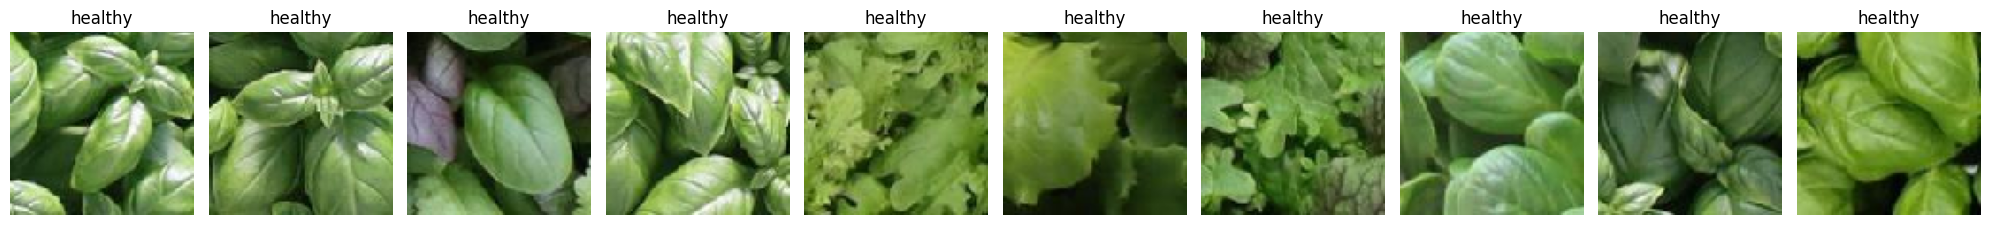

In [5]:
# Number of images to display
num_img = 10

# Create subplots for displaying 10 random items from the dataset
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
for i in range(num_img):
    value = randint(0, len(data))
    ax = axes[i%num_img]
    ax.imshow(data[value].astype(np.uint8), cmap = 'gray')
    label = labels[value]
    ax.set_title(f'{labels[value]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Prepare data

In [6]:
healthy = []
unhealthy = []

# Iterate through the images to separate them in the proper set
for i, image in enumerate(data):
    if (labels[i] == 'unhealthy'):
        unhealthy.append(image)
    else:
        healthy.append(image)

print(len(healthy))
print(len(unhealthy))


3060
1790


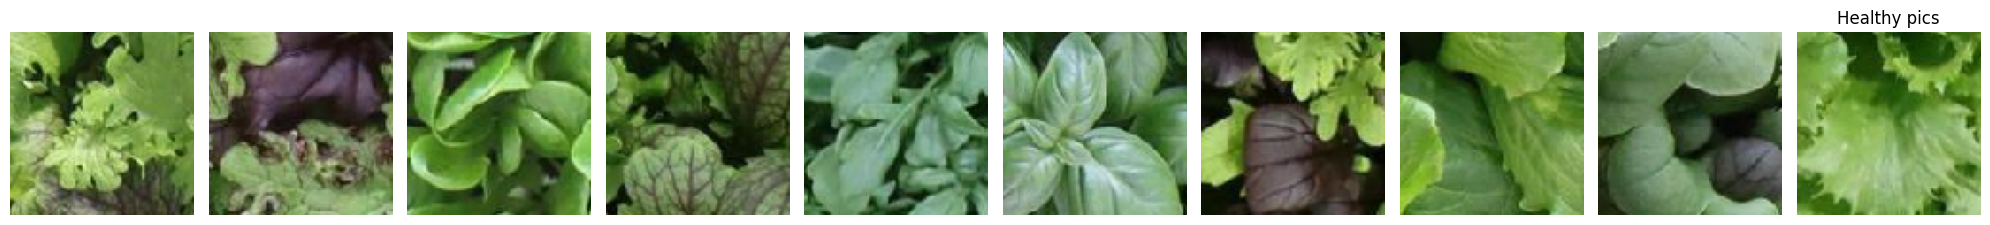

In [7]:
## CAN BE SKIPPED ##

# Number of images to display
num_img = 10

# Create subplots for displaying 10 healthy pics
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
plt.title("Healthy pics") 
for i in range(num_img):
    value = randint(0, len(healthy))
    ax = axes[i%num_img]
    ax.imshow(healthy[value].astype(np.uint8), cmap = 'gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

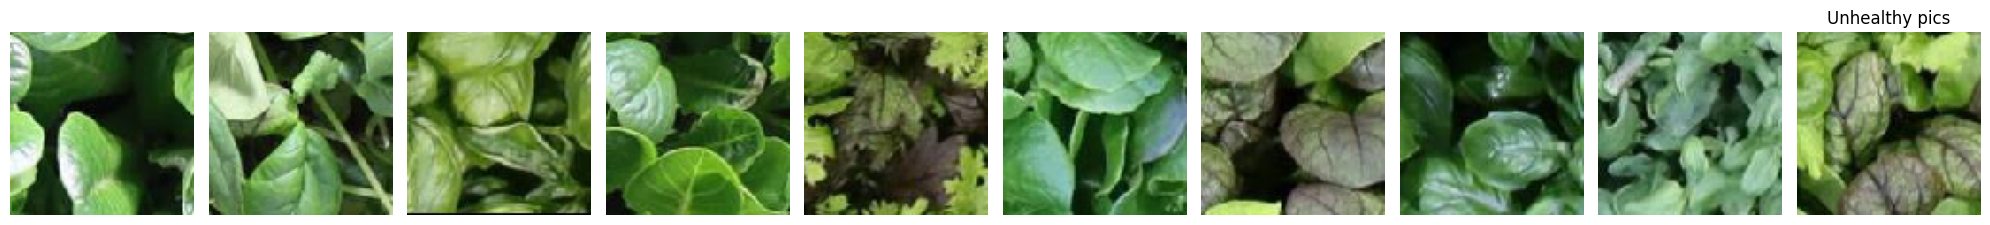

In [8]:
## CAN BE SKIPPED ##

# Number of images to display
num_img = 10

# Create subplots for displaying 10 random unhealthy pics
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
plt.title("Unhealthy pics") 
for i in range(num_img):
    value = randint(0, len(unhealthy))
    ax = axes[i%num_img]
    ax.imshow(unhealthy[value].astype(np.uint8), cmap = 'gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Fix randomness and hide warnings
seed = 42

#Concatenate 'healthy' and 'unhealthy'
X = np.concatenate([healthy, unhealthy], axis = 0)

# Create labels: 0 for 'healthy', 1 for 'unhealthy'
y = np.concatenate([np.ones(len(healthy)), np.zeros(len(unhealthy))], axis = 0)
y = tfk.utils.to_categorical(y, len(np.unique(y)))

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.20, stratify=np.argmax(y, axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val, axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (2910, 96, 96, 3), y_train shape: (2910, 2)
X_val shape: (970, 96, 96, 3), y_val shape: (970, 2)
X_test shape: (970, 96, 96, 3), y_test shape: (970, 2)


reminder **need to do image augmentation on unhealthy set which is clearly outnumbered**.

In [10]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 100

img_height = 96
img_width = 96

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (2,), Batch Size: 32, Epochs: 100


In [11]:
# Tells the model when to stop if values do not change
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True, mode='auto'),
]

### Train the model

In [12]:
# Macs with Apple Silicon suffer performance penalties when using the modern Adam optimizer
# Detect system specs and select the appropriate optimizer

if platform.system() == "Darwin" and platform.processor() == "arm":
    optimizer = tf.keras.optimizers.legacy.Adam()
else:
    optimizer = tf.keras.optimizers.Adam()

In [13]:
# Build the model sequentially
import platform

def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Return the model
    return model

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0       

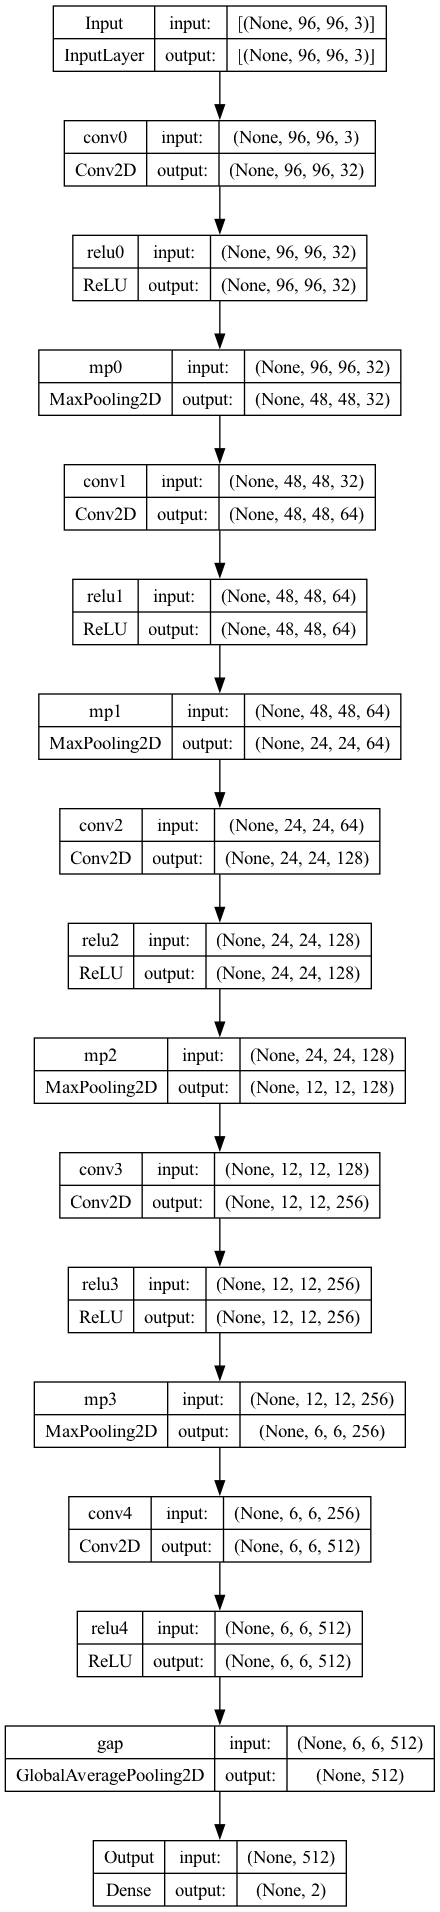

In [14]:
# Build the model and return a summary about it
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [15]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/100
91/91 [==============================] - 4s 42ms/step - loss: 3.4067 - accuracy: 0.6117 - val_loss: 0.6536 - val_accuracy: 0.6309
Epoch 2/100
91/91 [==============================] - 3s 34ms/step - loss: 0.6636 - accuracy: 0.6313 - val_loss: 0.6582 - val_accuracy: 0.6309
Epoch 3/100
91/91 [==============================] - 3s 35ms/step - loss: 0.6596 - accuracy: 0.6309 - val_loss: 0.6634 - val_accuracy: 0.6505
Epoch 4/100
91/91 [==============================] - 3s 34ms/step - loss: 0.6575 - accuracy: 0.6326 - val_loss: 0.6659 - val_accuracy: 0.6309
Epoch 5/100
91/91 [==============================] - 3s 35ms/step - loss: 0.6553 - accuracy: 0.6381 - val_loss: 0.6385 - val_accuracy: 0.6454
Epoch 6/100
91/91 [==============================] - 3s 32ms/step - loss: 0.6366 - accuracy: 0.6491 - val_loss: 0.6486 - val_accuracy: 0.6433
Epoch 7/100
91/91 [==============================] - 3s 32ms/step - loss: 0.6350 - accuracy: 0.6498 - val_loss: 0.6350 - val_accuracy: 0.6732
Epoch 

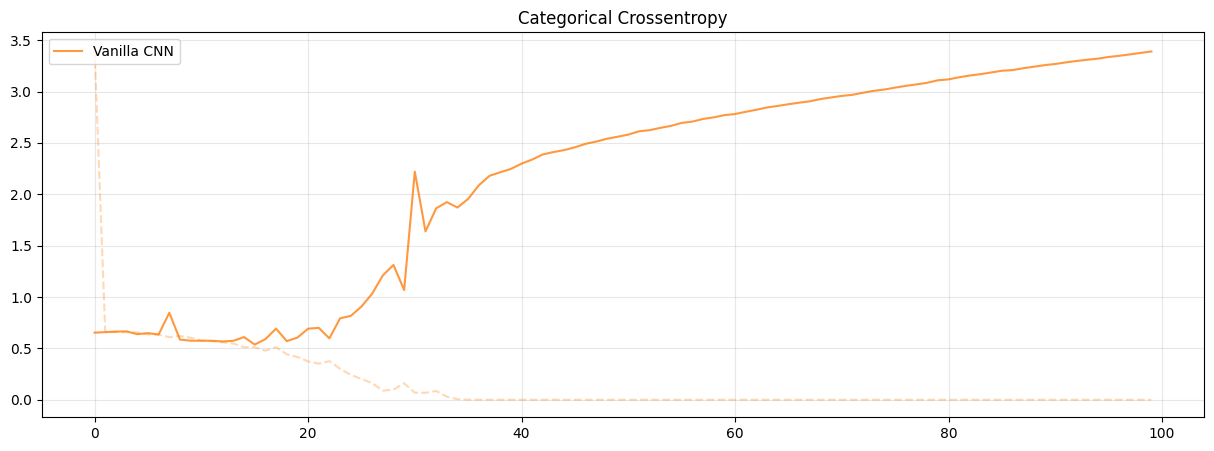

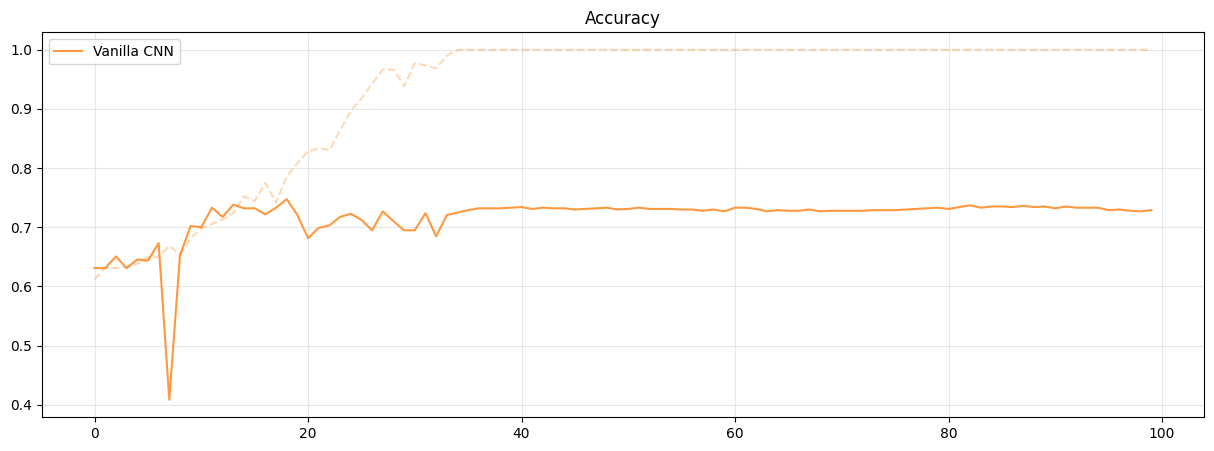

In [16]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()